In [13]:
using Random, Distributions
include("Box_Neumann_To_Dirichlet.jl")

Generate_Output (generic function with 2 methods)

# Generate Dirichlet results for box setup

The top Neumann boundary is 
$$u_g(x) = 1_{|x - x_0| < \frac{d_0}{2}}$$

Assume the wave speed is a constant c,
Consider the Neumann boundary $\frac{\partial u}{\partial n} = u_g(x)$ on the top, and $\frac{\partial u}{\partial n} = 0$ in all 
other boundaries.
The source term is $0$.
The ouput is a $N_p \times 2 \times 4$ tensor, Dirichlet results on four boundaries.


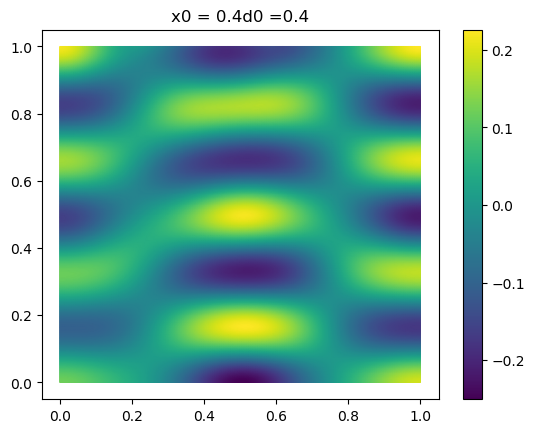

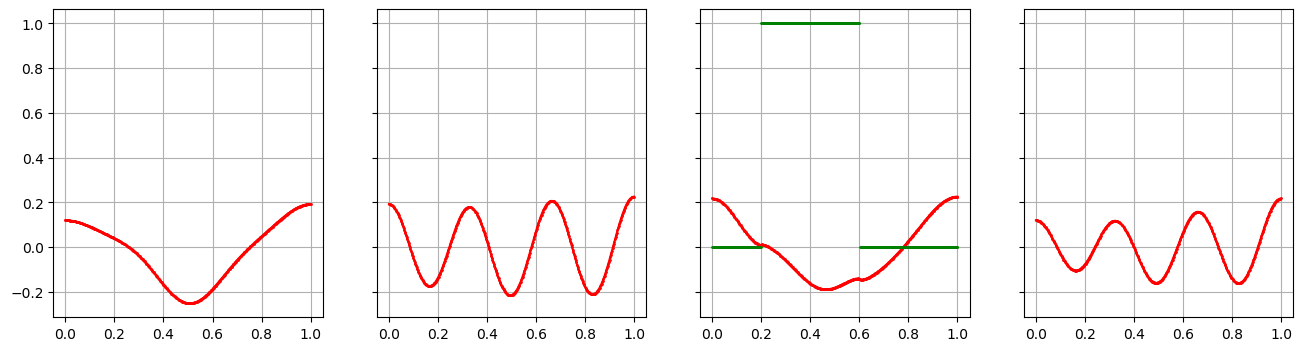

In [22]:
x0, d0 = 0.4, 0.4
c_func = (x, y)->50
ne = 200
porder = 2

output_data = N2D(x0, d0, c_func, ne, ne, porder, 3; visualize = true)

fig_disp, ax_disp = PyPlot.subplots(ncols = 4, nrows=1, sharex=false, sharey=true, figsize=(16,4))
markersize = 1

for bc_id = 1:4
    
    ax_disp[bc_id].plot(output_data[:, 1, bc_id], output_data[:, 2, bc_id], "-ro", markersize = markersize, label="Dirichlet")
    if bc_id == 3
        xx = output_data[:, 1, bc_id]
        Neumann_data = bump_func(xx, ones(Float64, size(xx)), x0, d0)
        ax_disp[bc_id].plot(xx, Neumann_data, "go", markersize = markersize, label="Neumann")
    
    end
    ax_disp[bc_id].grid()
end 
    

# Generate Dirichlet results for box setup

The top Neumann boundary is 
$$u_g(x) = 1_{|x - x_0| < \frac{d_0}{2}}$$

Assume the wave speed is a constant c,
Consider the Neumann boundary $\frac{\partial u}{\partial n} = u_g(x)$ on the top, and $\frac{\partial u}{\partial n} = 0$ in all 
other boundaries.
The source term is $0$.
The ouput is a $N_p \times N_cN_l \times 4$ tensor, Dirichlet results on four boundaries.


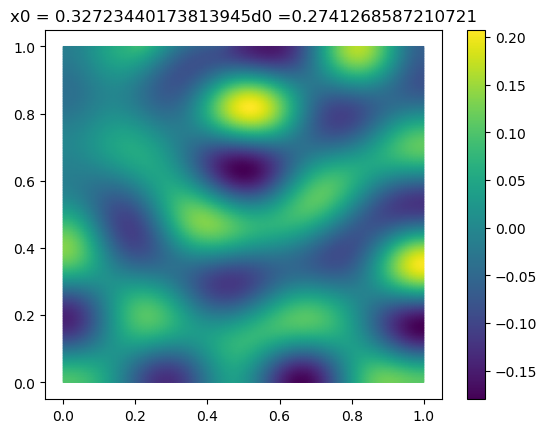

In [26]:

N_l = 100
ne = 100
porder = 2
cs = [50.0;]
x0d0s = rand(Uniform(0,1), N_l,2)
# generate Dirichlet to Neumman results output for differe
output_data = Generate_Output(cs,  x0d0s, ne, porder);



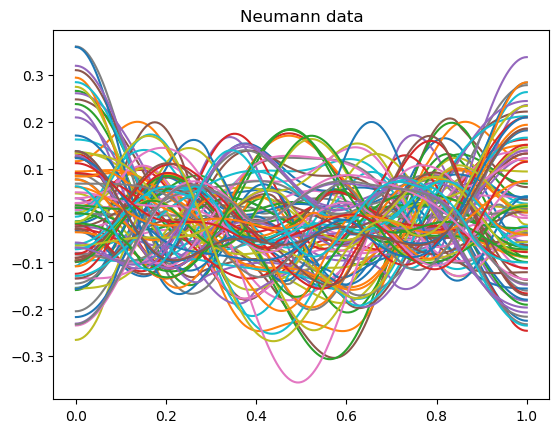

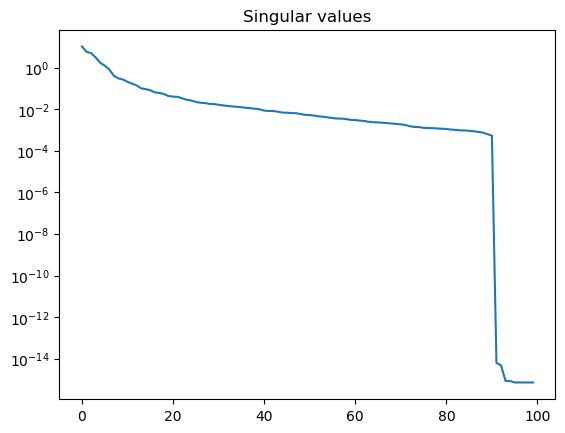

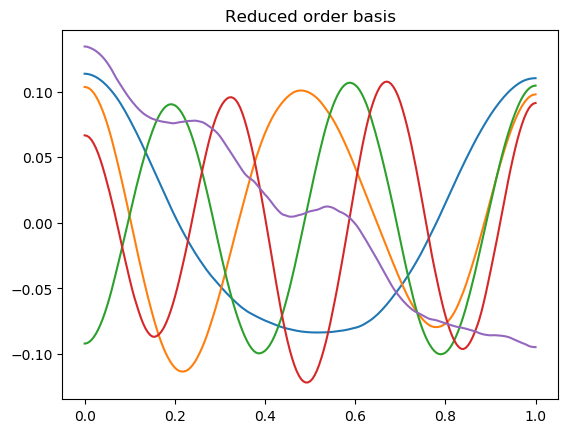

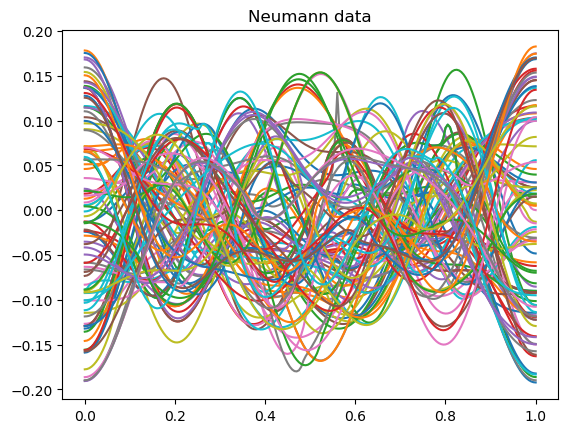

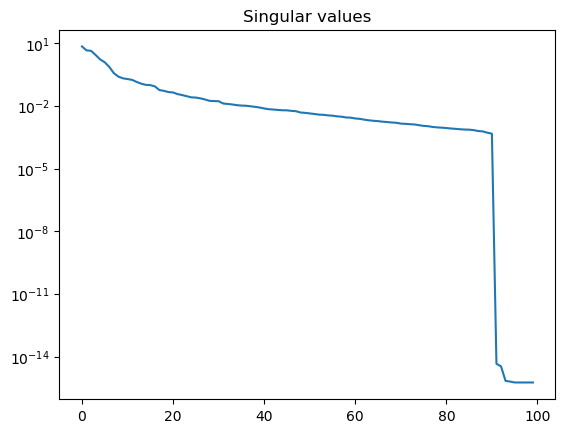

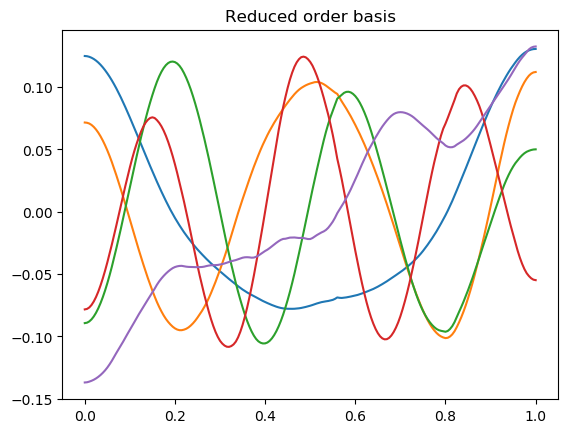

5-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8035801550>
 PyObject <matplotlib.lines.Line2D object at 0x7f805027a510>
 PyObject <matplotlib.lines.Line2D object at 0x7f805027a6d0>
 PyObject <matplotlib.lines.Line2D object at 0x7f805027a890>
 PyObject <matplotlib.lines.Line2D object at 0x7f805027aa50>

In [29]:
# consider on only the top edge
bc_id = 3
x = LinRange(0, 1, ne*porder+1)
PyPlot.figure()
PyPlot.title("Neumann data")
PyPlot.plot(x, output_data[:,:,bc_id])


PyPlot.figure()
PyPlot.title("Singular values")
U,Σ,V = svd(output_data[:,:,bc_id])
PyPlot.semilogy(Σ)

PyPlot.figure()
trunc = 5
PyPlot.title("Reduced order basis")
PyPlot.plot(x, U[:, 1:trunc])

# normalized the ouput
output_data_normalized = copy(output_data)
for i = 1:size(output_data, 2)
    for j = 1:size(output_data, 3)
        output_data_normalized[:,i,j] .= output_data_normalized[:,i,j]/norm(output_data_normalized[:,i,j])
    end
end

PyPlot.figure()
PyPlot.title("Neumann data")
PyPlot.plot(x, output_data_normalized[:,:,bc_id])

PyPlot.figure()
PyPlot.title("Singular values")
U,Σ,V = svd(output_data_normalized[:,:,bc_id])
PyPlot.semilogy(Σ)

PyPlot.figure()
PyPlot.title("Reduced order basis")
trunc = 5
PyPlot.plot(x, U[:, 1:trunc])

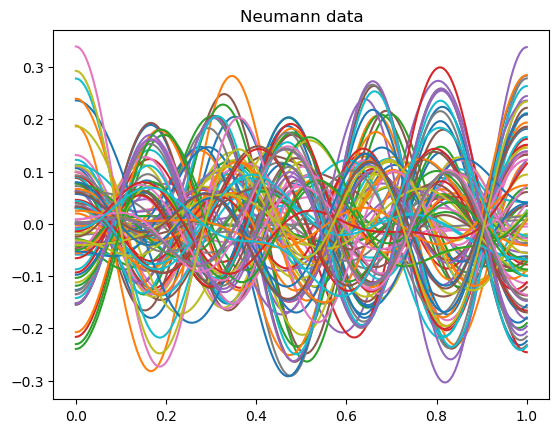

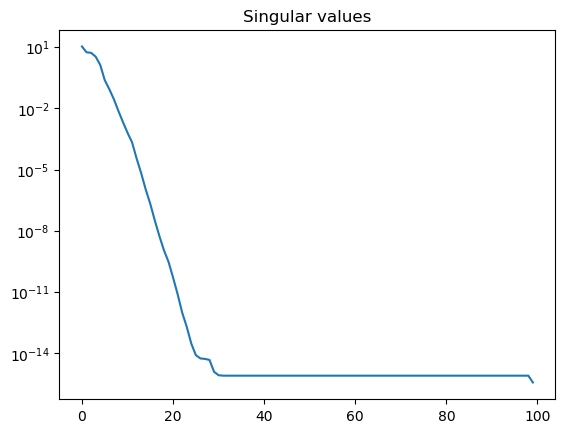

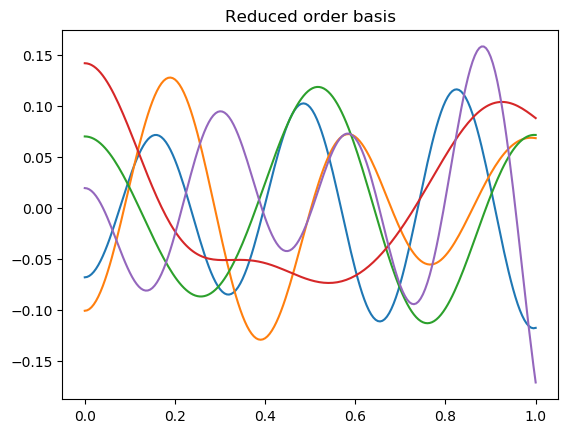

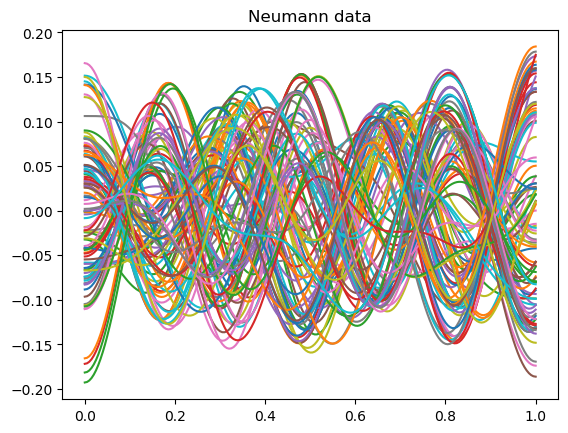

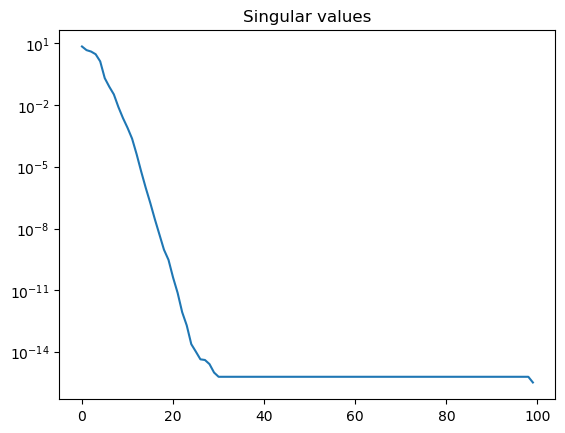

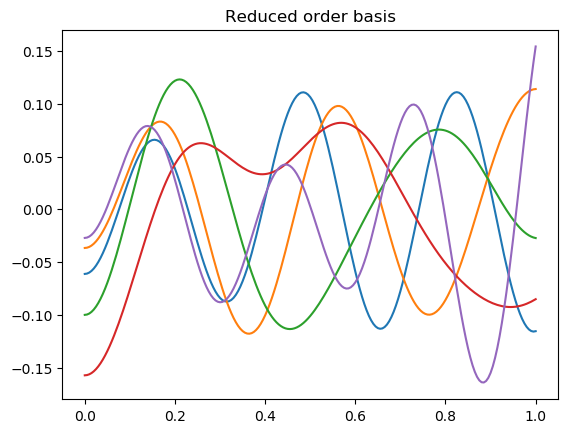

5-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f804229d950>
 PyObject <matplotlib.lines.Line2D object at 0x7f8042357910>
 PyObject <matplotlib.lines.Line2D object at 0x7f8042357ad0>
 PyObject <matplotlib.lines.Line2D object at 0x7f8042357c90>
 PyObject <matplotlib.lines.Line2D object at 0x7f8042357e50>

In [30]:
# consider on only the left edge
bc_id = 2
x = LinRange(0, 1, ne*porder+1)
PyPlot.figure()
PyPlot.title("Neumann data")
PyPlot.plot(x, output_data[:,:,bc_id])


PyPlot.figure()
PyPlot.title("Singular values")
U,Σ,V = svd(output_data[:,:,bc_id])
PyPlot.semilogy(Σ)

PyPlot.figure()
trunc = 5
PyPlot.title("Reduced order basis")
PyPlot.plot(x, U[:, 1:trunc])

# normalized the ouput
output_data_normalized = copy(output_data)
for i = 1:size(output_data, 2)
    for j = 1:size(output_data, 3)
        output_data_normalized[:,i,j] .= output_data_normalized[:,i,j]/norm(output_data_normalized[:,i,j])
    end
end

PyPlot.figure()
PyPlot.title("Neumann data")
PyPlot.plot(x, output_data_normalized[:,:,bc_id])

PyPlot.figure()
PyPlot.title("Singular values")
U,Σ,V = svd(output_data_normalized[:,:,bc_id])
PyPlot.semilogy(Σ)

PyPlot.figure()
PyPlot.title("Reduced order basis")
trunc = 5
PyPlot.plot(x, U[:, 1:trunc])